In [1]:
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random


In [14]:

def parse_jssp_file(filename):
    jobs_data = []

    with open(filename, "r") as f:
        # Enlever les lignes de commentaires
        lines = [
            line.strip()
            for line in f
            if line.strip() and not line.strip().startswith("#")
        ]

    # Première ligne : nb jobs, nb machines
    num_jobs, num_machines = map(int, lines[0].split())

    # Lignes suivantes : jobs
    for i in range(1, num_jobs + 1):
        data = list(map(int, lines[i].split()))
        job = []

        for k in range(0, len(data), 2):
            machine = data[k]
            duration = data[k + 1]
            job.append((machine, duration))

        jobs_data.append(job)

    return jobs_data, num_jobs, num_machines

jobs_data, num_jobs, num_machines = parse_jssp_file("ta34.txt")


In [15]:
# Horizon = somme de toutes les durées (borne large)
horizon = sum(duration for job in jobs_data for _, duration in job)

# -------------------------
# Modèle CP
# -------------------------
model = cp_model.CpModel()

start = {}
end = {}
interval = {}

# -------------------------
# Variables
# -------------------------
for j, job in enumerate(jobs_data):
    for t, (machine, duration) in enumerate(job):
        start[j, t] = model.NewIntVar(0, horizon, f'start_{j}_{t}')
        end[j, t] = model.NewIntVar(0, horizon, f'end_{j}_{t}')
        interval[j, t] = model.NewIntervalVar(
            start[j, t],
            duration,
            end[j, t],
            f'interval_{j}_{t}'
        )



# Makespan
makespan = model.NewIntVar(0, horizon, 'makespan')

# -------------------------
# Contraintes
# -------------------------

# 1️⃣ Ordre des tâches dans chaque job
for j, job in enumerate(jobs_data):
    for t in range(len(job) - 1):
        model.Add(start[j, t + 1] >= end[j, t])

# 2️⃣ Une seule tâche à la fois par machine
for m in range(num_machines):
    machine_intervals = []
    for j, job in enumerate(jobs_data):
        for t, (machine, _) in enumerate(job):
            if machine == m:
                machine_intervals.append(interval[j, t])
    model.AddNoOverlap(machine_intervals)

# 3️⃣ Définition du makespan
for j, job in enumerate(jobs_data):
    last_task = len(job) - 1
    model.Add(makespan >= end[j, last_task])

# -------------------------
# Objectif
# -------------------------
model.Minimize(makespan)



In [18]:
# -------------------------
# Résolution
# -------------------------
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 600.0
status = solver.Solve(model)

# -------------------------
# Affichage
# -------------------------
if status == cp_model.OPTIMAL:
    print(f"Optimal makespan = {solver.Value(makespan)}\n")
    for j, job in enumerate(jobs_data):
        for t, (machine, duration) in enumerate(job):
            print(
                f"Job {j} Task {t} | Machine {machine} "
                f"| start = {solver.Value(start[j, t])} "
                f"| end = {solver.Value(end[j, t])}"
            )

In [17]:
def compute_lower_bound(jobs_data, num_machines):
    # LB par job
    lb_job = max(sum(d for _, d in job) for job in jobs_data)

    # LB par machine
    machine_load = [0] * num_machines
    for job in jobs_data:
        for m, d in job:
            machine_load[m] += d
    lb_machine = max(machine_load)

    return max(lb_job, lb_machine)


In [8]:

import time
from ortools.sat.python import cp_model

def solve_jssp_decision(jobs_data, num_machines, T, time_limit=2.0):
    horizon = sum(d for job in jobs_data for _, d in job)

    model = cp_model.CpModel()
    start, end, interval = {}, {}, {}

    for j, job in enumerate(jobs_data):
        for t, (m, d) in enumerate(job):
            start[j,t] = model.NewIntVar(0, horizon, f"s_{j}_{t}")
            end[j,t]   = model.NewIntVar(0, horizon, f"e_{j}_{t}")
            interval[j,t] = model.NewIntervalVar(start[j,t], d, end[j,t], f"int_{j}_{t}")

    makespan = model.NewIntVar(0, horizon, "makespan")

    # Contraintes d’ordre des jobs
    for j, job in enumerate(jobs_data):
        for t in range(len(job)-1):
            model.Add(start[j,t+1] >= end[j,t])

    # Contraintes machines
    for m in range(num_machines):
        intervals = []
        for j, job in enumerate(jobs_data):
            for t, (mach, _) in enumerate(job):
                if mach == m:
                    intervals.append(interval[j,t])
        model.AddNoOverlap(intervals)

    # makespan
    for j, job in enumerate(jobs_data):
        model.Add(makespan >= end[j, len(job)-1])

    # 🔥 Décision
    model.Add(makespan <= T)

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit

    t0 = time.time()
    status = solver.Solve(model)
    elapsed = time.time() - t0

    return {
        "feasible": status in (cp_model.OPTIMAL, cp_model.FEASIBLE),
        "time": elapsed,
        "branches": solver.NumBranches(),
        "conflicts": solver.NumConflicts()
    }


In [9]:
alphas = [1.22, 1.24, 1.26, 1.28, 1.30, 1.32, 1.34, 1.36, 1.38, 1.40, 1.42, 1.44, 1.46, 1.48, 1.50]
alphas_ta34 = [1.00, 1.02, 1.04, 1.06, 1.08,1.09, 1.093, 1.10, 1.11, 1.12, 1.16, 1.18, 1.20]
alphas_la30= [ 1.00, 1.02, 1.04, 1.06, 1.08,1.09, 1.093, 1.10, 1.11, 1.12, 1.16, 1.18, 1.20]

In [10]:

import math
import statistics

LB = compute_lower_bound(jobs_data, num_machines)

results = []

for alpha in alphas:
    T = math.ceil(alpha * LB)
    r = solve_jssp_decision(jobs_data, num_machines, T)

    results.append({
        "alpha": alpha,
        "T": T,
        "feasible": r["feasible"],
        "time": r["time"],
        "branches": r["branches"],
        "conflicts": r["conflicts"]
    })

    print(f"α={alpha:.2f} | T={T} | feasible={r['feasible']} "
          f"| time={r['time']:.3f}s | branches={r['branches']}")


α=1.22 | T=1059 | feasible=False | time=0.003s | branches=0
α=1.24 | T=1077 | feasible=False | time=0.002s | branches=0
α=1.26 | T=1094 | feasible=False | time=0.001s | branches=0
α=1.28 | T=1112 | feasible=False | time=0.002s | branches=0
α=1.30 | T=1129 | feasible=False | time=0.008s | branches=8
α=1.32 | T=1146 | feasible=False | time=0.013s | branches=93
α=1.34 | T=1164 | feasible=False | time=0.014s | branches=147
α=1.36 | T=1181 | feasible=False | time=0.023s | branches=282
α=1.38 | T=1198 | feasible=False | time=0.184s | branches=1688
α=1.40 | T=1216 | feasible=False | time=0.282s | branches=2735
α=1.42 | T=1233 | feasible=False | time=1.126s | branches=31736
α=1.44 | T=1250 | feasible=True | time=0.006s | branches=50
α=1.46 | T=1268 | feasible=True | time=0.035s | branches=1507
α=1.48 | T=1285 | feasible=True | time=0.013s | branches=232
α=1.50 | T=1302 | feasible=True | time=0.011s | branches=401


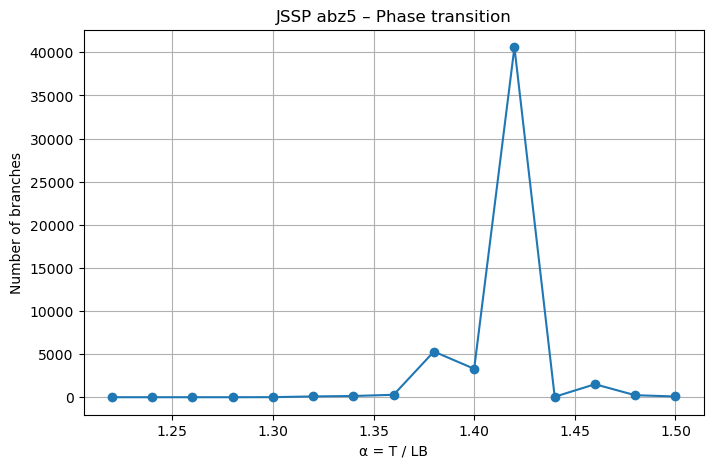

In [90]:
import matplotlib.pyplot as plt

alphas = [r["alpha"] for r in results]
branches = [r["branches"] for r in results]
times = [r["time"] for r in results]

plt.figure(figsize=(8,5))
plt.plot(alphas, branches, marker='o')
plt.xlabel("α = T / LB")
plt.ylabel("Number of branches")
plt.title("JSSP abz5 – Phase transition")
plt.grid(True)
plt.show()
